# ML in drug research

## Data parsing [task 1]
Спарсим данные по всем молекулам из chembl таргетом для которых является cox-2. Также проведем их первичную обработку.

#### Parsing activities

Отбираем важные фичи из chembl api и собираем данные по acitivities

In [ ]:
important_fields = [
 'activity_id',
 'assay_chembl_id',
 'bao_endpoint',
 'bao_format',
 'bao_label',
 'canonical_smiles',
 'molecule_chembl_id',
 'parent_molecule_chembl_id',
 'pchembl_value',
 'potential_duplicate',
 'relation',
 'standard_flag',
 'standard_relation',
 'standard_text_value',
 'standard_type',
 'standard_units',
 'standard_upper_value',
 'standard_value',
 'target_chembl_id',
 'target_organism',
 'target_pref_name',
 'target_tax_id',
]

In [ ]:
!mkdir /content/logs

In [ ]:
import logging
logging.basicConfig(
    filename="/content/logs/activities_chembl_parse.log",
    level=logging.INFO,
    force = True,
    format="%(asctime)s [%(levelname)s] %(message)s"
)

In [ ]:
import requests
import time
from pprint import pprint
from random import uniform


headers = {'Accept': 'application/json'}
target_id = "CHEMBL230"
limit = 100



def extract_features(activities):
  extract = lambda x: {key:x[key] for key in important_fields}
  objs = []
  for act in activities:
    objs.append(extract(act))
  return objs


def parse_activities_data(target_id, limit, headers):
  rows = []
  offset = 0
  logging.info('...Start...')
  while True:
    try:
      url = f'https://www.ebi.ac.uk/chembl/api/data/activity?target_chembl_id={target_id}&limit={limit}&offset={offset}'
      req = requests.get(url, headers=headers)
      if not req.json()['activities']:
        break
      rows.extend(extract_features(req.json()['activities']))
      logging.info(f'parsed {len(rows)} objects')
      offset += limit
    except Exception as ex:
      logging.info(f'parsing error: request code - {req.status_code}, exception: {ex.message}')

  return rows

rows = parse_activities_data(target_id, limit, headers)

Данные скачались - мы получили 14150 записей

In [ ]:
len(rows)

14150

In [ ]:
!mkdir drive/MyDrive/datacon2025

Сохраняем их в отдельный файл, чтобы в следующий раз не скачивать заново.

In [ ]:
import json

json.dump(
    obj = rows,
    fp = open('drive/MyDrive/datacon2025/activities_jsons_raw.json', 'w')
)

#### Creating Dataframe

Переносим наши данные в формат датафрейма

In [ ]:
df_dict = {key: [] for key in rows[0].keys()}
for obj in rows:
  for key in df_dict.keys():
    df_dict[key].append(obj[key])

In [ ]:
import pandas as pd
df = pd.DataFrame(df_dict)

И сохраняем его тоже

In [ ]:
df = pd.read_csv('drive/MyDrive/datacon2025/activities_dataframe.csv', index_col=0)

Мы видим что среди 14к записей уникальными являются лишь ~8600 молекул. Учтем это в дальнейшей обработке.

In [ ]:
len(df['molecule_chembl_id'].unique())

8694

#### Preprocessing

In [ ]:
df['standard_type'].value_counts()

,count
standard_type,
IC50,7979
Inhibition,3350
AC50,1193
Ki,899
Activity,418
Ratio IC50,110
-log(RatioIC50),42
NT,20
% Ctrl,19


Оставим только те записи, для которых stadard_type равен ic50

In [ ]:
ic50_df = df[df['standard_type'] == 'IC50']
ic50_df.shape

(7979, 22)

In [ ]:
ic50_df.columns

Index(['activity_id', 'assay_chembl_id', 'bao_endpoint', 'bao_format',
       'bao_label', 'canonical_smiles', 'molecule_chembl_id',
       'parent_molecule_chembl_id', 'pchembl_value', 'potential_duplicate',
       'relation', 'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id'],
      dtype='object')

Колонка target_organism не несет никакой информации - можно дропать

In [ ]:
ic50_df['target_organism'].value_counts()

,count
target_organism,
Homo sapiens,7979


In [ ]:
ic50_df = ic50_df.drop(['target_organism'], axis = 1)
ic50_df.columns

Index(['activity_id', 'assay_chembl_id', 'bao_endpoint', 'bao_format',
       'bao_label', 'canonical_smiles', 'molecule_chembl_id',
       'parent_molecule_chembl_id', 'pchembl_value', 'potential_duplicate',
       'relation', 'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_pref_name',
       'target_tax_id'],
      dtype='object')

Тоже самое касается признаков вида target_

In [ ]:
ic50_df['target_chembl_id'].value_counts()

,count
target_chembl_id,
CHEMBL230,7979


In [ ]:
ic50_df = ic50_df.drop(['target_chembl_id', 'target_pref_name', 'target_tax_id'], axis = 1)
ic50_df.columns

Index(['activity_id', 'assay_chembl_id', 'bao_endpoint', 'bao_format',
       'bao_label', 'canonical_smiles', 'molecule_chembl_id',
       'parent_molecule_chembl_id', 'pchembl_value', 'potential_duplicate',
       'relation', 'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value'],
      dtype='object')

Из всех измерений будем оставлять только те записи, в которых значение измерения является точным числом, а не порогом.

In [ ]:
ic50_df['standard_relation'].value_counts()

,count
standard_relation,
=,5948
>,973
<,56
>=,1


In [ ]:
ic50_df = ic50_df[ic50_df['standard_relation'] == '=']
ic50_df.shape

(5948, 18)

Выкидываем колонки связанные с типом измерения

In [ ]:
ic50_df = ic50_df.drop(['relation', 'standard_relation'], axis = 1)
ic50_df.columns

Index(['activity_id', 'assay_chembl_id', 'bao_endpoint', 'bao_format',
       'bao_label', 'canonical_smiles', 'molecule_chembl_id',
       'parent_molecule_chembl_id', 'pchembl_value', 'potential_duplicate',
       'standard_flag', 'standard_text_value', 'standard_type',
       'standard_units', 'standard_upper_value', 'standard_value'],
      dtype='object')

In [ ]:
ic50_df.shape

(5948, 16)

Видим, что у нас в данных есть разные форматы исследований. Для того, чтобы датасет был более репрезентативным - оставим только лишь наиболее многочисленный тип эксперимента - single protein format

In [ ]:
ic50_df['bao_label'].value_counts()

,count
bao_label,
single protein format,4545
cell-based format,694
tissue-based format,553
assay format,145
organism-based format,11


In [ ]:
ic50_df = ic50_df[ic50_df['bao_label'] == 'single protein format']
ic50_df.shape

(4545, 16)

In [ ]:
ic50_df['bao_endpoint'].value_counts(),ic50_df['bao_format'].value_counts()

(bao_endpoint
 BAO_0000190    4545
 Name: count, dtype: int64,
 bao_format
 BAO_0000357    4545
 Name: count, dtype: int64)

Теперь и все колонки типа bao можно выкинуть

In [ ]:
ic50_df = ic50_df.drop(['bao_label', 'bao_format', 'bao_endpoint'], axis = 1)
ic50_df.columns

Index(['activity_id', 'assay_chembl_id', 'canonical_smiles',
       'molecule_chembl_id', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'standard_flag', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value'],
      dtype='object')

In [ ]:
ic50_df.shape

(4545, 13)

Почти все оставшиеся записи имеют единецей измерения ic50 nM. Есть 17 записей в ug.mL-1 и еще по одной записи других единиц измерения. Последние два варианта мы просто отбросим - так как это всего две записи. А 17 конвертируем в nM

In [ ]:
ic50_df['standard_units'].value_counts()

,count
standard_units,
nM,4526
ug.mL-1,17
ug,1
%,1


In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 51.7 MB/s eta 0:00:00


Преобразуем все объекты с ug.mL-1 в nM

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def convert_to_nM(smiles, value):
  mol = Chem.MolFromSmiles(smiles)
  mol_weight = Descriptors.MolWt(mol)
  nM = (value * 1e-3 / mol_weight) * 1e9
  return nM

converted_values = ic50_df.apply(lambda x: convert_to_nM(x['canonical_smiles'],float(x['standard_value'])) if x['standard_units'] == 'ug.mL-1' else float(x['standard_value']), axis = 1)


In [ ]:
ic50_df['converted_values'] = converted_values
ic50_df.columns

Index(['activity_id', 'assay_chembl_id', 'canonical_smiles',
       'molecule_chembl_id', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'standard_flag', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'converted_values'],
      dtype='object')

In [ ]:
ic50_df.shape

(4545, 14)

In [ ]:
(ic50_df['standard_value'] == ic50_df['converted_values']).sum() + 17

np.int64(4545)

Выкидываем два объекта с не релевантными единицами измерения

In [ ]:
ic50_df = ic50_df[(ic50_df['standard_units'] == 'ug.mL-1') | (ic50_df['standard_units']== 'nM')]

In [ ]:
ic50_df.columns

Index(['activity_id', 'assay_chembl_id', 'canonical_smiles',
       'molecule_chembl_id', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'standard_flag', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'converted_values'],
      dtype='object')

In [ ]:
ic50_df.head()

,activity_id,assay_chembl_id,canonical_smiles,molecule_chembl_id,parent_molecule_chembl_id,pchembl_value,potential_duplicate,standard_flag,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,converted_values
0,34205,CHEMBL762912,Cc1ccc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccccc1,CHEMBL297008,CHEMBL297008,7.22,0,1,NaN,IC50,nM,NaN,60.00,60.00
1,34209,CHEMBL762912,Cc1c(C=O)cc(-c2ccc(S(C)(=O)=O)cc2)n1-c1ccc(F)cc1,CHEMBL289813,CHEMBL289813,5.49,0,1,NaN,IC50,nM,NaN,3230.00,3230.00
2,35476,CHEMBL762912,Cc1c(COc2cccc(Cl)c2)cc(-c2ccc(S(C)(=O)=O)cc2)n...,CHEMBL43736,CHEMBL43736,7.10,0,1,NaN,IC50,nM,NaN,80.00,80.00
3,36218,CHEMBL769655,Fc1ccc(-c2[nH]c(-c3ccc(F)cc3)c3c2C2CCC3CC2)cc1,CHEMBL140167,CHEMBL140167,9.92,0,1,NaN,IC50,nM,NaN,0.12,0.12
5,39073,CHEMBL762912,CC(=O)c1cc(-c2ccc(S(C)(=O)=O)cc2)n(-c2ccc(F)cc...,CHEMBL44290,CHEMBL44290,5.79,0,1,NaN,IC50,nM,NaN,1610.00,1610.00


In [ ]:
ic50_df['standard_flag'].value_counts()

,count
standard_flag,
1,4543


In [ ]:
ic50_df['standard_text_value'].value_counts()

,count
standard_text_value,


In [ ]:
ic50_df['standard_upper_value'].value_counts()

,count
standard_upper_value,


Все эти колонки не несут смысла (как видно из строчек выше) - поэтому их также выкидываем

In [ ]:
ic50_df = ic50_df.drop(['standard_upper_value', 'standard_text_value', 'standard_flag'], axis = 1)
ic50_df.columns

Index(['activity_id', 'assay_chembl_id', 'canonical_smiles',
       'molecule_chembl_id', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'standard_type', 'standard_units',
       'standard_value', 'converted_values'],
      dtype='object')

Видим, что среди оставшихся записей есть дубликаты молекул. Учитывая, что разные эксперименты, проведенные в разных условиях могут колебаться в своих результатах, кажется, что самым верным вариантом будет взять медиану целевой величины - ic50

In [ ]:
ic50_df['molecule_chembl_id'].value_counts()

,count
molecule_chembl_id,
CHEMBL118,167
CHEMBL6,87
CHEMBL521,30
CHEMBL122,24
CHEMBL7162,21
...,...
CHEMBL5431270,1
CHEMBL5396677,1
CHEMBL5403077,1


<Axes: >

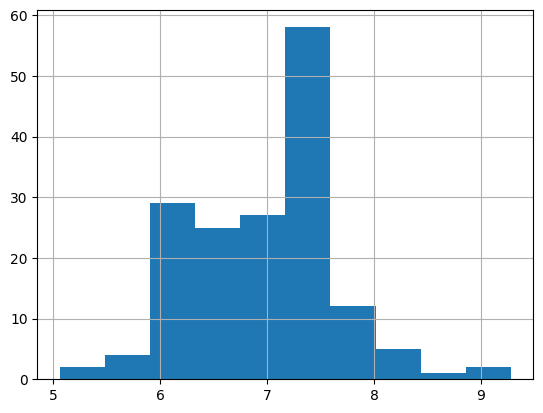

In [ ]:
ic50_df[ic50_df['molecule_chembl_id'] == 'CHEMBL118']['pchembl_value'].hist()

Аргерируем повторяющиеся молекулы

In [ ]:
final_df = ic50_df.groupby('molecule_chembl_id').agg({
    'canonical_smiles': 'first',
    'converted_values': 'median',
    'pchembl_value': 'median'
})

final_df

,canonical_smiles,converted_values,pchembl_value
molecule_chembl_id,,,
CHEMBL100091,CCCCOCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(...,60.0,7.22
CHEMBL100092,CCCCCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(O...,60.0,7.22
CHEMBL100156,CS(=O)(=O)c1ccc(-c2cscc2-c2ccccc2)cc1,4000.0,5.40
CHEMBL100250,CS(=O)(=O)c1ccc(-c2ccsc2-c2ccccc2)cc1,4000.0,5.40
CHEMBL100331,CCCCCCCCNC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc...,40.0,7.40
...,...,...,...
CHEMBL99374,Cc1ccc(-c2cscc2-c2ccc(S(C)(=O)=O)cc2)cc1,4000.0,5.40
CHEMBL99517,Cc1ccc(-c2sccc2-c2ccc(S(C)(=O)=O)cc2)cc1,13000.0,4.89
CHEMBL99727,CCOC(=O)CCc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(...,130000.0,NaN


Теперь логарифмируем и приведем к более приятному виду значения standard value

In [ ]:
import numpy as np

def pchembl_from_nM(nM_value):
    molar = nM_value * 1e-9
    return -np.log10(molar)

Выкидываем нулевые значения

In [ ]:
final_df.shape

(3396, 3)

In [ ]:
final_df = final_df[final_df['converted_values'] != 0]

In [ ]:
final_df.shape

(3390, 3)

In [ ]:
final_df['log_ic50(pchembl)'] = pchembl_from_nM(final_df['converted_values'])
final_df

/tmp/ipython-input-53-1061664099.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['log_ic50(pchembl)'] = pchembl_from_nM(final_df['converted_values'])


,canonical_smiles,converted_values,pchembl_value,log_ic50(pchembl)
molecule_chembl_id,,,,
CHEMBL100091,CCCCOCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(...,60.0,7.22,7.221849
CHEMBL100092,CCCCCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(O...,60.0,7.22,7.221849
CHEMBL100156,CS(=O)(=O)c1ccc(-c2cscc2-c2ccccc2)cc1,4000.0,5.40,5.397940
CHEMBL100250,CS(=O)(=O)c1ccc(-c2ccsc2-c2ccccc2)cc1,4000.0,5.40,5.397940
CHEMBL100331,CCCCCCCCNC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc...,40.0,7.40,7.397940
...,...,...,...,...
CHEMBL99374,Cc1ccc(-c2cscc2-c2ccc(S(C)(=O)=O)cc2)cc1,4000.0,5.40,5.397940
CHEMBL99517,Cc1ccc(-c2sccc2-c2ccc(S(C)(=O)=O)cc2)cc1,13000.0,4.89,4.886057
CHEMBL99727,CCOC(=O)CCc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(...,130000.0,NaN,3.886057


In [ ]:
final_df = final_df.reset_index()

In [ ]:
final_df = final_df.drop(['converted_values', 'pchembl_value'], axis = 1)
final_df

,molecule_chembl_id,canonical_smiles,log_ic50(pchembl)
0,CHEMBL100091,CCCCOCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(...,7.221849
1,CHEMBL100092,CCCCCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(O...,7.221849
2,CHEMBL100156,CS(=O)(=O)c1ccc(-c2cscc2-c2ccccc2)cc1,5.397940
3,CHEMBL100250,CS(=O)(=O)c1ccc(-c2ccsc2-c2ccccc2)cc1,5.397940
4,CHEMBL100331,CCCCCCCCNC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc...,7.397940
...,...,...,...
3385,CHEMBL99374,Cc1ccc(-c2cscc2-c2ccc(S(C)(=O)=O)cc2)cc1,5.397940
3386,CHEMBL99517,Cc1ccc(-c2sccc2-c2ccc(S(C)(=O)=O)cc2)cc1,4.886057
3387,CHEMBL99727,CCOC(=O)CCc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(...,3.886057
3388,CHEMBL99828,Cc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(F)cc2)s1,5.000000


Финальный шаг - проверим валидность smiles

In [ ]:
from rdkit import Chem

def is_valid_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

final_df["canonical_smiles"].apply(is_valid_smiles).sum() == final_df.shape[0]

np.True_

In [ ]:
final_df

,molecule_chembl_id,canonical_smiles,log_ic50(pchembl)
0,CHEMBL100091,CCCCOCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(...,7.221849
1,CHEMBL100092,CCCCCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(O...,7.221849
2,CHEMBL100156,CS(=O)(=O)c1ccc(-c2cscc2-c2ccccc2)cc1,5.397940
3,CHEMBL100250,CS(=O)(=O)c1ccc(-c2ccsc2-c2ccccc2)cc1,5.397940
4,CHEMBL100331,CCCCCCCCNC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc...,7.397940
...,...,...,...
3385,CHEMBL99374,Cc1ccc(-c2cscc2-c2ccc(S(C)(=O)=O)cc2)cc1,5.397940
3386,CHEMBL99517,Cc1ccc(-c2sccc2-c2ccc(S(C)(=O)=O)cc2)cc1,4.886057
3387,CHEMBL99727,CCOC(=O)CCc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(...,3.886057
3388,CHEMBL99828,Cc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(F)cc2)s1,5.000000


Сохраняем полученные данные

In [ ]:
final_df.to_csv('/content/drive/MyDrive/datacon2025/final_df_task1.csv')

## Descriptors (feature extraction) [task 2]

- RDkit descriptors
- Mordred descriptors
- MACCS fingerprints
- Morgen fingerprints



#### RDkit

In [ ]:
!pip install rdkit

In [3]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from tqdm.notebook import tqdm

In [4]:
final_df = pd.read_csv('/content/drive/MyDrive/datacon2025/final_df_task1.csv', index_col = 0)
final_df

,molecule_chembl_id,canonical_smiles,log_ic50(pchembl)
0,CHEMBL100091,CCCCOCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(...,7.221849
1,CHEMBL100092,CCCCCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(O...,7.221849
2,CHEMBL100156,CS(=O)(=O)c1ccc(-c2cscc2-c2ccccc2)cc1,5.397940
3,CHEMBL100250,CS(=O)(=O)c1ccc(-c2ccsc2-c2ccccc2)cc1,5.397940
4,CHEMBL100331,CCCCCCCCNC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc...,7.397940
...,...,...,...
3385,CHEMBL99374,Cc1ccc(-c2cscc2-c2ccc(S(C)(=O)=O)cc2)cc1,5.397940
3386,CHEMBL99517,Cc1ccc(-c2sccc2-c2ccc(S(C)(=O)=O)cc2)cc1,4.886057
3387,CHEMBL99727,CCOC(=O)CCc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(...,3.886057
3388,CHEMBL99828,Cc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(F)cc2)s1,5.000000


Создадим таблицу значений всех дескрипторов из rdkit

In [5]:
descriptor_list = Descriptors.descList

descriptor_names = [name for name, func in descriptor_list]

def calc_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    values = []
    for name, func in descriptor_list:
        try:
            val = func(mol)
        except:
            val = None
        values.append(val)
    return values

desc_values = final_df["canonical_smiles"].apply(calc_descriptors)
desc_df = pd.DataFrame(desc_values.tolist(), columns=descriptor_names)
desc_df

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.299115,13.299115,0.046983,-0.367590,0.308874,11.000000,457.954,429.730,457.165601,170,...,0,0,0,0,0,0,0,0,1,0
1,13.290871,13.290871,0.101366,-0.291287,0.303112,10.967742,441.955,413.731,441.170686,164,...,0,0,0,0,0,0,0,0,3,0
2,11.521156,11.521156,0.349760,-3.148077,0.713775,11.476190,314.431,300.319,314.043522,106,...,0,0,1,0,0,0,0,1,0,0
3,11.521156,11.521156,0.349760,-3.148077,0.713775,11.476190,314.431,300.319,314.043522,106,...,0,0,1,0,0,0,0,1,0,0
4,13.353022,13.353022,0.034750,-0.154564,0.334799,11.030303,469.025,435.761,468.217971,176,...,0,0,0,0,0,0,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,11.553057,11.553057,0.350338,-3.152845,0.692258,11.545455,328.458,312.330,328.059172,112,...,0,0,1,0,0,0,0,1,0,0
3386,11.553057,11.553057,0.350338,-3.152845,0.692258,11.545455,328.458,312.330,328.059172,112,...,0,0,1,0,0,0,0,1,0,0
3387,13.364568,13.364568,0.246956,-3.277701,0.486331,11.413793,432.538,411.370,432.086529,152,...,0,0,1,0,0,0,0,1,0,0
3388,13.133786,13.133786,0.262886,-3.202678,0.673488,11.608696,346.448,331.328,346.049750,118,...,0,0,1,0,0,0,0,1,0,0


In [67]:
desc_df.to_csv('/content/drive/MyDrive/datacon2025/rdkit_descriptors.csv')

Выделим фичи, в которых есть пропуски

In [92]:
nans = desc_df.isna().sum()
nans[nans > 0]

,0
MaxPartialCharge,9
MinPartialCharge,9
MaxAbsPartialCharge,9
MinAbsPartialCharge,9
BCUT2D_MWHI,34
BCUT2D_MWLOW,34
BCUT2D_CHGHI,34
BCUT2D_CHGLO,34
BCUT2D_LOGPHI,34
BCUT2D_LOGPLOW,34


Так как пропусков не много можно заполнить их медианными значениями

In [93]:
nans = desc_df.isna().sum().to_dict()
nan_features = []
for key in nans:
  if nans[key] >0:
    nan_features.append(key)

nan_features

['MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW']

Заполняем пропуски медианными значениями

In [94]:
df_desc_filled = desc_df.fillna(desc_df.median())
(df_desc_filled.isna().sum() > 0).sum()

np.int64(0)

Удаляем колонки с нулевой дисперсией

In [95]:
zero_var_cols = [c for c in df_desc_filled.columns if df_desc_filled[c].nunique() <= 1]
zero_var_cols

['NumRadicalElectrons',
 'SMR_VSA8',
 'SlogP_VSA9',
 'fr_benzodiazepine',
 'fr_diazo',
 'fr_dihydropyridine',
 'fr_isocyan',
 'fr_isothiocyan',
 'fr_lactam',
 'fr_phos_acid',
 'fr_phos_ester',
 'fr_prisulfonamd',
 'fr_quatN']

In [96]:
df_desc_filled = df_desc_filled.drop(zero_var_cols, axis = 1)
len(df_desc_filled.columns)

204

Из признаков с взаимной корреляцией больше 0.7 удаляем один

In [97]:
import numpy as np

corr_matrix = df_desc_filled.corr().abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [
    column for column in upper.columns if any(upper[column] > 0.95)
]

to_drop

['MaxEStateIndex',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'Kappa1',
 'Kappa2',
 'LabuteASA',
 'HeavyAtomCount',
 'NOCount',
 'NumHAcceptors',
 'NumHDonors',
 'Phi',
 'MolMR',
 'fr_Al_OH',
 'fr_Al_OH_noTert',
 'fr_COO2',
 'fr_Nhpyrrole',
 'fr_amide',
 'fr_benzene',
 'fr_nitrile',
 'fr_nitro_arom',
 'fr_phenol',
 'fr_phenol_noOrthoHbond']

In [98]:
df_desc_filled = df_desc_filled.drop(to_drop, axis = 1)
len(df_desc_filled.columns)

169

Сохраняем дескрипторы для rdkit

In [99]:
df_desc_filled.to_csv('/content/drive/MyDrive/datacon2025/prerared_rdkit_descriptors.csv')

#### Mordred

In [100]:
!pip install mordred

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 94.6 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176718 sha256=6f6ae76d4c1076b3b25339b452702f3df7d87aa114e7035fc1a5a2f0cb701e60
  Stored in directory: /root/.cache/pip/wheels/8b/30/0b/84e3f6775306e74cf5957ee4d16b10bf3927dcec44cc23d5f2
Successfully built mordred
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: networkx
    Found existing installation: networkx 3.5
    Uninstalling networkx-3.5:
      Successfully uninstalled networkx-3.5
ERROR: pip's dependency resolver does not currently t

In [1]:
import pandas as pd
from rdkit import Chem
from mordred import Calculator, descriptors
from tqdm import tqdm

In [2]:
final_df = pd.read_csv('/content/drive/MyDrive/datacon2025/final_df_task1.csv', index_col = 0)
final_df

,molecule_chembl_id,canonical_smiles,log_ic50(pchembl)
0,CHEMBL100091,CCCCOCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(...,7.221849
1,CHEMBL100092,CCCCCCOC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc(O...,7.221849
2,CHEMBL100156,CS(=O)(=O)c1ccc(-c2cscc2-c2ccccc2)cc1,5.397940
3,CHEMBL100250,CS(=O)(=O)c1ccc(-c2ccsc2-c2ccccc2)cc1,5.397940
4,CHEMBL100331,CCCCCCCCNC(=O)Cc1c(C)n(C(=O)c2ccc(Cl)cc2)c2ccc...,7.397940
...,...,...,...
3385,CHEMBL99374,Cc1ccc(-c2cscc2-c2ccc(S(C)(=O)=O)cc2)cc1,5.397940
3386,CHEMBL99517,Cc1ccc(-c2sccc2-c2ccc(S(C)(=O)=O)cc2)cc1,4.886057
3387,CHEMBL99727,CCOC(=O)CCc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(...,3.886057
3388,CHEMBL99828,Cc1cc(-c2ccc(S(C)(=O)=O)cc2)c(-c2ccc(F)cc2)s1,5.000000


Также берем вытаскиваем значения всех дескрипторов из mordred

In [11]:
calc = Calculator(descriptors, ignore_3D=True)


def calc_mordred(smiles):
    mol = Chem.MolFromSmiles(smiles)
    try:
        return calc(mol)
    except:
        return None

# Оборачиваем в tqdm
mordred_results = []
for smiles in tqdm(final_df["canonical_smiles"], desc="Calculating descriptors"):
    res = calc_mordred(smiles)
    mordred_results.append(res)

mordred_dicts = [r.asdict() if r is not None else {} for r in mordred_results]
mordred_df = pd.DataFrame(mordred_dicts)

Calculating descriptors:   0%|          | 0/3390 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [22]:
mordred_df.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,40.898747,2.545115,4.91204,40.898747,1.278086,4.373637,...,10.288376,82.283776,457.165601,7.619427,3195,50,160.0,187.0,11.111111,7.361111
1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,39.469365,2.545115,4.91204,39.469365,1.273205,4.344482,...,10.279764,81.191304,441.170686,7.477469,2854,49,156.0,183.0,10.861111,7.111111
2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,27.074024,2.43033,4.804856,27.074024,1.289239,3.984858,...,9.978920,68.660780,314.043522,8.972672,955,31,112.0,131.0,6.618056,4.500000
3,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,27.074024,2.43033,4.804856,27.074024,1.289239,3.984858,...,9.978920,68.660780,314.043522,8.972672,955,31,112.0,131.0,6.618056,4.500000
4,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,42.034289,2.545115,4.91204,42.034289,1.273766,4.401967,...,10.296914,83.374302,468.217971,7.094212,3568,51,164.0,191.0,11.361111,7.611111


In [12]:
mordred_df.shape

(3390, 1613)

In [13]:
mordred_df.to_csv('/content/drive/MyDrive/datacon2025/mordred_descriptors_raw.csv')

In [14]:
mordred_df.shape

(3390, 1613)

Пустых значений нет

In [15]:
mordred_df.isnull().sum().sum()

0

Удаляем признаки с нулевой дисперсией

In [16]:
zero_var_cols = [c for c in mordred_df.columns if mordred_df[c].nunique() <= 1]
zero_var_cols

['NsLi',
 'NssBe',
 'NssssBe',
 'NssBH',
 'NsssB',
 'NssssB',
 'NddC',
 'NsNH3',
 'NssNH2',
 'NsssNH',
 'NssssN',
 'NsSiH3',
 'NssSiH2',
 'NsssSiH',
 'NsPH2',
 'NssPH',
 'NsssP',
 'NsssssP',
 'NdssS',
 'NsGeH3',
 'NssGeH2',
 'NsssGeH',
 'NssssGe',
 'NsAsH2',
 'NssAsH',
 'NsssAs',
 'NsssdAs',
 'NsssssAs',
 'NsSeH',
 'NdSe',
 'NdssSe',
 'NddssSe',
 'NsSnH3',
 'NssSnH2',
 'NsssSnH',
 'NssssSn',
 'NsPbH3',
 'NssPbH2',
 'NsssPbH',
 'NssssPb',
 'SsLi',
 'SssBe',
 'SssssBe',
 'SssBH',
 'SsssB',
 'SssssB',
 'SddC',
 'SsNH3',
 'SssNH2',
 'SsssNH',
 'SssssN',
 'SsSiH3',
 'SssSiH2',
 'SsssSiH',
 'SsPH2',
 'SssPH',
 'SsssP',
 'SsssssP',
 'SdssS',
 'SsGeH3',
 'SssGeH2',
 'SsssGeH',
 'SssssGe',
 'SsAsH2',
 'SssAsH',
 'SsssAs',
 'SsssdAs',
 'SsssssAs',
 'SsSeH',
 'SdSe',
 'SdssSe',
 'SddssSe',
 'SsSnH3',
 'SssSnH2',
 'SsssSnH',
 'SssssSn',
 'SsPbH3',
 'SssPbH2',
 'SsssPbH',
 'SssssPb',
 'SMR_VSA8',
 'SlogP_VSA9',
 'n8Ring',
 'n4HRing',
 'n8HRing',
 'n9HRing',
 'n10HRing',
 'n3aRing',
 'n4aRing',
 'n7

In [17]:
mordred_df = mordred_df.drop(columns=zero_var_cols)

In [18]:
mordred_df.shape

(3390, 1483)

Удаляем убираем дублирующие признаки

In [19]:
import numpy as np

corr_matrix = mordred_df.corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [column for column in upper.columns if any(upper[column] > .95)]
to_drop

['SpAD_A',
 'VE3_A',
 'VR2_A',
 'nAromBond',
 'nHeavyAtom',
 'nH',
 'nC',
 'ATS2dv',
 'ATS3dv',
 'ATS4dv',
 'ATS5dv',
 'ATS6dv',
 'ATS7dv',
 'ATS8dv',
 'ATS0d',
 'ATS1d',
 'ATS2d',
 'ATS3d',
 'ATS4d',
 'ATS5d',
 'ATS6d',
 'ATS7d',
 'ATS8d',
 'ATS1s',
 'ATS4s',
 'ATS5s',
 'ATS6s',
 'ATS7s',
 'ATS8s',
 'ATS2Z',
 'ATS3Z',
 'ATS4Z',
 'ATS5Z',
 'ATS6Z',
 'ATS7Z',
 'ATS8Z',
 'ATS0m',
 'ATS1m',
 'ATS2m',
 'ATS3m',
 'ATS4m',
 'ATS5m',
 'ATS6m',
 'ATS7m',
 'ATS8m',
 'ATS0v',
 'ATS1v',
 'ATS2v',
 'ATS3v',
 'ATS4v',
 'ATS5v',
 'ATS6v',
 'ATS7v',
 'ATS8v',
 'ATS0se',
 'ATS1se',
 'ATS2se',
 'ATS3se',
 'ATS4se',
 'ATS5se',
 'ATS6se',
 'ATS7se',
 'ATS8se',
 'ATS0pe',
 'ATS1pe',
 'ATS2pe',
 'ATS3pe',
 'ATS4pe',
 'ATS5pe',
 'ATS6pe',
 'ATS7pe',
 'ATS8pe',
 'ATS0are',
 'ATS1are',
 'ATS2are',
 'ATS3are',
 'ATS4are',
 'ATS5are',
 'ATS6are',
 'ATS7are',
 'ATS8are',
 'ATS0p',
 'ATS1p',
 'ATS2p',
 'ATS3p',
 'ATS4p',
 'ATS5p',
 'ATS6p',
 'ATS7p',
 'ATS8p',
 'ATS0i',
 'ATS1i',
 'ATS2i',
 'ATS3i',
 'ATS4i',
 'A

In [23]:
len(to_drop)

758

In [24]:
mordred_df = mordred_df.drop(to_drop, axis = 1)
mordred_df.shape

(3390, 725)

В ходе вычисления признаков появилось много ошибок. Удалим полностью некорректные признаки и заполним медианой признаки с малым числом пропусков

In [25]:
mordred_df.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpMAD_A,LogEE_A,VE1_A,...,GGI9,JGI3,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,SRW05
0,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,40.898747,2.545115,4.91204,1.278086,4.373637,4.109712,...,0.205941,0.055972,0.030850,0.018571,0.014616,0.011365,0.006436,0.007911,1.000000,2.397895
1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,39.469365,2.545115,4.91204,1.273205,4.344482,4.109223,...,0.205941,0.057115,0.031480,0.018975,0.014964,0.011005,0.006865,0.008228,0.888889,2.397895
2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,27.074024,2.43033,4.804856,1.289239,3.984858,4.136352,...,0.110000,0.040099,0.026933,0.015462,0.017003,0.018277,0.012222,0.008862,0.833333,2.397895
3,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,27.074024,2.43033,4.804856,1.289239,3.984858,4.136352,...,0.110000,0.040099,0.026933,0.015462,0.017003,0.018277,0.012222,0.008862,0.833333,2.397895
4,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,42.034289,2.545115,4.91204,1.273766,4.401967,4.10995,...,0.225941,0.054875,0.030245,0.018184,0.014283,0.011073,0.006847,0.007346,0.900000,2.397895


In [26]:
temp = mordred_df.astype(float)

In [27]:
nans = temp.isna().sum()
drop_cols = nans[nans > 41].index
temp = temp.drop(drop_cols, axis = 1)
temp = temp.fillna(temp.median())

In [28]:
temp.isna().sum().sum()

0

In [29]:
temp.shape

(3390, 598)

In [30]:
temp.to_csv('/content/drive/MyDrive/datacon2025/mordred_descriptors_prepared.csv')

#### Morgan fingerprints

Также создадим таблицу для morgan fingerprints

In [38]:
from rdkit import RDLogger
from rdkit.Chem import AllChem
RDLogger.DisableLog('rdApp.warning')


def compute_morgan_fingerprints(smiles_list, n_bits=2048, radius=2):
    fps_array = []
    for smi in tqdm(smiles_list, desc="Morgan fingerprints"):
        mol = Chem.MolFromSmiles(smi)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits)
        arr = np.zeros((n_bits,), dtype=int)
        AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
        fps_array.append(arr)

    fps_df = pd.DataFrame(fps_array, columns=[f"morgan_{i}" for i in range(n_bits)])

    return fps_df


morgan_fps = compute_morgan_fingerprints(
    smiles_list=final_df["canonical_smiles"],
    n_bits=2048,
    radius=2
)

Morgan fingerprints:   0%|          | 0/3390 [00:00<?, ?it/s]

In [39]:
morgan_fps.shape

(3390, 2048)

In [40]:
morgan_fps.head()

,morgan_0,morgan_1,morgan_2,morgan_3,morgan_4,morgan_5,morgan_6,morgan_7,morgan_8,morgan_9,...,morgan_2038,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
base_dir = '/content/drive/MyDrive/datacon2025/'
morgan_fps.to_csv(base_dir + 'morgan_fps.csv')

#### MACSS fingerprints

Аналогично создадим macss fingerprints

In [42]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import MACCSkeys
import numpy as np
from tqdm import tqdm

def compute_maccs_fingerprints(smiles_list):
    fps_array = []

    for smi in tqdm(smiles_list, desc="MACCS fingerprints"):
        mol = Chem.MolFromSmiles(smi)
        fp = MACCSkeys.GenMACCSKeys(mol)
        arr = np.zeros((fp.GetNumBits(),), dtype=int)
        Chem.DataStructs.ConvertToNumpyArray(fp, arr)
        fps_array.append(arr)

    fps_df = pd.DataFrame(fps_array, columns=[f"maccs_{i}" for i in range(167)])

    return fps_df


maccs_fps = compute_maccs_fingerprints(final_df["canonical_smiles"])

MACCS fingerprints: 100%|██████████| 3390/3390 [00:04<00:00, 703.36it/s]


In [43]:
maccs_fps.shape

(3390, 167)

In [44]:
maccs_fps.head()

,maccs_0,maccs_1,maccs_2,maccs_3,maccs_4,maccs_5,maccs_6,maccs_7,maccs_8,maccs_9,...,maccs_157,maccs_158,maccs_159,maccs_160,maccs_161,maccs_162,maccs_163,maccs_164,maccs_165,maccs_166
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [45]:
maccs_fps.to_csv(base_dir + 'maccs_fingerprints')

## ML models [task 3]

- Random Forest
- Gradient boosting (catboost)
- MLP
- CNN (for fingerprints)


In [46]:
import random
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

### Random Forest (в каждой модели сделать итоговое обучение, проверить на тесте и сохранить модель, также добавить пайплайн для нормализации и очистки от выбросов)

#### RDkit descriptors

In [49]:
df_desc_filled = pd.read_csv('/content/drive/MyDrive/datacon2025/prerared_rdkit_descriptors.csv', index_col=0)
df_desc_filled

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.299115,0.046983,-0.367590,0.308874,11.000000,457.954,0.309930,-0.496743,0.496743,0.309930,...,0,0,0,0,0,0,0,0,1,0
1,13.290871,0.101366,-0.291287,0.303112,10.967742,441.955,0.309845,-0.496743,0.496743,0.309845,...,0,0,0,0,0,0,0,0,3,0
2,11.521156,0.349760,-3.148077,0.713775,11.476190,314.431,0.175019,-0.223991,0.223991,0.175019,...,0,0,1,0,0,0,0,1,0,0
3,11.521156,0.349760,-3.148077,0.713775,11.476190,314.431,0.175019,-0.223991,0.223991,0.175019,...,0,0,1,0,0,0,0,1,0,0
4,13.353022,0.034750,-0.154564,0.334799,11.030303,469.025,0.262092,-0.496743,0.496743,0.262092,...,0,0,0,0,0,0,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,11.553057,0.350338,-3.152845,0.692258,11.545455,328.458,0.175019,-0.223991,0.223991,0.175019,...,0,0,1,0,0,0,0,1,0,0
3386,11.553057,0.350338,-3.152845,0.692258,11.545455,328.458,0.175019,-0.223991,0.223991,0.175019,...,0,0,1,0,0,0,0,1,0,0
3387,13.364568,0.246956,-3.277701,0.486331,11.413793,432.538,0.305636,-0.465960,0.465960,0.305636,...,0,0,1,0,0,0,0,1,0,0
3388,13.133786,0.262886,-3.202678,0.673488,11.608696,346.448,0.175019,-0.223991,0.223991,0.175019,...,0,0,1,0,0,0,0,1,0,0


In [50]:
df_desc_filled['target'] = final_df['log_ic50(pchembl)']
df_desc_filled = df_desc_filled.copy()
df_desc_filled

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,target
0,13.299115,0.046983,-0.367590,0.308874,11.000000,457.954,0.309930,-0.496743,0.496743,0.309930,...,0,0,0,0,0,0,0,1,0,7.221849
1,13.290871,0.101366,-0.291287,0.303112,10.967742,441.955,0.309845,-0.496743,0.496743,0.309845,...,0,0,0,0,0,0,0,3,0,7.221849
2,11.521156,0.349760,-3.148077,0.713775,11.476190,314.431,0.175019,-0.223991,0.223991,0.175019,...,0,1,0,0,0,0,1,0,0,5.397940
3,11.521156,0.349760,-3.148077,0.713775,11.476190,314.431,0.175019,-0.223991,0.223991,0.175019,...,0,1,0,0,0,0,1,0,0,5.397940
4,13.353022,0.034750,-0.154564,0.334799,11.030303,469.025,0.262092,-0.496743,0.496743,0.262092,...,0,0,0,0,0,0,0,5,0,7.397940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,11.553057,0.350338,-3.152845,0.692258,11.545455,328.458,0.175019,-0.223991,0.223991,0.175019,...,0,1,0,0,0,0,1,0,0,5.397940
3386,11.553057,0.350338,-3.152845,0.692258,11.545455,328.458,0.175019,-0.223991,0.223991,0.175019,...,0,1,0,0,0,0,1,0,0,4.886057
3387,13.364568,0.246956,-3.277701,0.486331,11.413793,432.538,0.305636,-0.465960,0.465960,0.305636,...,0,1,0,0,0,0,1,0,0,3.886057
3388,13.133786,0.262886,-3.202678,0.673488,11.608696,346.448,0.175019,-0.223991,0.223991,0.175019,...,0,1,0,0,0,0,1,0,0,5.000000


<Axes: >

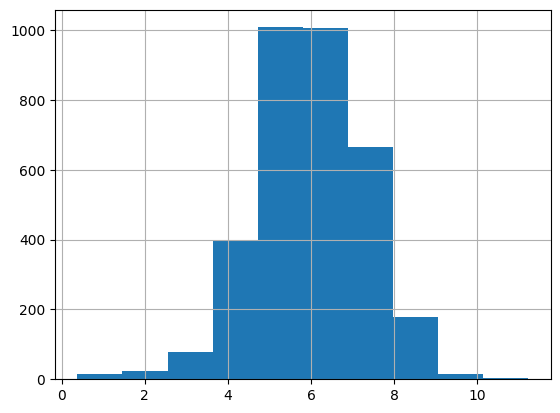

In [51]:
df_desc_filled['target'].hist()

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score

In [104]:
X = df_desc_filled.drop(['target'], axis = 1)
y = df_desc_filled['target']
X.shape, y.shape

((3390, 169), (3390,))

In [115]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Кастомный трансформер для обработки выбросов
class OutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor
        self.bounds_ = {}

    def fit(self, X, y=None):
        # Сохраняем границы для каждой колонки
        self.bounds_ = {}
        X_df = pd.DataFrame(X)
        for col in X_df.columns:
            Q1 = X_df[col].quantile(0.25)
            Q3 = X_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - self.factor * IQR
            upper = Q3 + self.factor * IQR
            self.bounds_[col] = (lower, upper)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X).copy()
        for col in X_df.columns:
            lower, upper = self.bounds_[col]
            X_df[col] = X_df[col].clip(lower, upper)
        return X_df.values


pipeline = Pipeline([
    ("clip_outliers", OutlierClipper(factor=3)),
    #("scale", StandardScaler())
])

X_scaled = pipeline.fit_transform(X)



In [101]:
model = RandomForestRegressor(n_estimators=100, random_state=SEED)

In [106]:
from sklearn.model_selection import cross_validate

scoring = {
    "neg_mse": "neg_mean_squared_error",
    "r2": "r2",
    "mae": "neg_mean_absolute_error"
}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    model, X_scaled, y,
    scoring=scoring,
    cv=kf,
    return_train_score=True,
    n_jobs=-1
)

# Результаты
print("Test MSE:", -cv_results['test_neg_mse'])
print("Test MAE:", -cv_results['test_mae'])
print("Test R2:", cv_results['test_r2'])

Test MSE: [0.73395083 0.70178386 0.83685728 0.68071061 0.790028  ]
Test MAE: [0.63333021 0.60851934 0.660825   0.59766959 0.62090406]
Test R2: [0.5664175  0.61781574 0.52573873 0.56241647 0.51972135]


In [121]:
print("Test mean MSE:", np.mean(-cv_results['test_neg_mse']))
print("Test mean MAE:", np.mean(-cv_results['test_mae']))
print("Test mean R2:", np.mean(cv_results['test_r2']))

Test mean MSE: 0.7486661179681139
Test mean MAE: 0.6242496394154115
Test mean R2: 0.5584219579646932


In [111]:
model.fit(X_scaled, y)

RandomForestRegressor(random_state=42)

In [114]:
sorted(dict(zip(X.columns, model.feature_importances_)).items(), key = lambda x: -x[1])[:10]

[('SlogP_VSA8', 0.051018146709442186),
 ('PEOE_VSA11', 0.040628079097216184),
 ('VSA_EState2', 0.040535118210115975),
 ('VSA_EState3', 0.03755431795866498),
 ('BCUT2D_MWHI', 0.0369438158286692),
 ('BCUT2D_MWLOW', 0.03281874400333627),
 ('BCUT2D_LOGPHI', 0.032281852620078294),
 ('BCUT2D_LOGPLOW', 0.023907990813280402),
 ('BCUT2D_CHGHI', 0.0214924768973767),
 ('MinPartialCharge', 0.01774279236253734)]

#### Mordred descriptors

In [77]:
temp['target'] = final_df['log_ic50(pchembl)']
temp = temp.copy()
temp

,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VR1_A,...,JGI3,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TopoShapeIndex,SRW05,target
0,0.0,0.0,40.898747,2.545115,4.912040,1.278086,4.373637,4.109712,0.128428,4715.076859,...,0.055972,0.030850,0.018571,0.014616,0.011365,0.006436,0.007911,1.000000,2.397895,7.221849
1,0.0,0.0,39.469365,2.545115,4.912040,1.273205,4.344482,4.109223,0.132556,2399.084322,...,0.057115,0.031480,0.018975,0.014964,0.011005,0.006865,0.008228,0.888889,2.397895,7.221849
2,0.0,0.0,27.074024,2.430330,4.804856,1.289239,3.984858,4.136352,0.196969,128.065383,...,0.040099,0.026933,0.015462,0.017003,0.018277,0.012222,0.008862,0.833333,2.397895,5.397940
3,0.0,0.0,27.074024,2.430330,4.804856,1.289239,3.984858,4.136352,0.196969,128.065383,...,0.040099,0.026933,0.015462,0.017003,0.018277,0.012222,0.008862,0.833333,2.397895,5.397940
4,0.0,0.0,42.034289,2.545115,4.912040,1.273766,4.401967,4.109950,0.124544,9485.047291,...,0.054875,0.030245,0.018184,0.014283,0.011073,0.006847,0.007346,0.900000,2.397895,7.397940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,0.0,0.0,27.905834,2.434193,4.812597,1.268447,4.030171,4.215674,0.191622,136.473424,...,0.039562,0.030300,0.019743,0.019618,0.019031,0.010909,0.009298,1.000000,2.397895,5.397940
3386,0.0,0.0,27.905834,2.434193,4.812597,1.268447,4.030171,4.215674,0.191622,136.473424,...,0.039562,0.030300,0.019743,0.019618,0.019031,0.010909,0.009298,1.000000,2.397895,4.886057
3387,0.0,0.0,36.264930,2.463673,4.842154,1.250515,4.285891,4.381470,0.151085,418.030608,...,0.042959,0.027172,0.014909,0.017796,0.016698,0.008477,0.008917,1.000000,2.397895,3.886057
3388,0.0,0.0,28.845321,2.455144,4.833598,1.254144,4.073577,4.222610,0.183592,152.478333,...,0.049206,0.033784,0.018217,0.021780,0.020927,0.008571,0.009298,1.000000,2.397895,5.000000


In [78]:
X = temp.drop(['target'], axis = 1)
y = temp['target']
X.shape, y.shape

((3390, 598), (3390,))

In [79]:
model = RandomForestRegressor(n_estimators=100, random_state=SEED)

In [80]:
from sklearn.model_selection import cross_validate

scoring = {
    "neg_mse": "neg_mean_squared_error",
    "r2": "r2",
    "mae": "neg_mean_absolute_error"
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    model, X, y,
    scoring=scoring,
    cv=kf,
    return_train_score=True,
    n_jobs=-1
)

# Результаты
print("Test MSE:", -cv_results['test_neg_mse'])
print("Test MAE:", -cv_results['test_mae'])
print("Test R2:", cv_results['test_r2'])

Test MSE: [0.76040042 0.78341398 0.83215641 0.70657133 0.78217206]
Test MAE: [0.66540713 0.64951237 0.67773245 0.61641937 0.63427675]
Test R2: [0.55079237 0.57336081 0.5284028  0.54579234 0.52449718]


#### MACCS fingerprints

In [81]:
maccs_fps
maccs_fps['target'] = final_df['log_ic50(pchembl)']
maccs_fps = maccs_fps.copy()
maccs_fps

,maccs_0,maccs_1,maccs_2,maccs_3,maccs_4,maccs_5,maccs_6,maccs_7,maccs_8,maccs_9,...,maccs_158,maccs_159,maccs_160,maccs_161,maccs_162,maccs_163,maccs_164,maccs_165,maccs_166,target
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,7.221849
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,7.221849
2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,0,5.397940
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,0,5.397940
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,7.397940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,0,5.397940
3386,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,0,4.886057
3387,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,0,3.886057
3388,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,0,5.000000


In [82]:
X = maccs_fps.drop(['target'], axis = 1)
y = maccs_fps['target']
X.shape, y.shape

((3390, 167), (3390,))

In [83]:
from sklearn.model_selection import cross_validate

scoring = {
    "neg_mse": "neg_mean_squared_error",
    "r2": "r2",
    "mae": "neg_mean_absolute_error"
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(
    model, X, y,
    scoring=scoring,
    cv=kf,
    return_train_score=True,
    n_jobs=-1
)

# Результаты
print("Test MSE:", -cv_results['test_neg_mse'])
print("Test MAE:", -cv_results['test_mae'])
print("Test R2:", cv_results['test_r2'])

Test MSE: [0.68904026 0.70260276 0.82152444 0.6613949  0.75913517]
Test MAE: [0.59376581 0.58946362 0.63226507 0.57278652 0.60550862]
Test R2: [0.59294848 0.61736977 0.53442812 0.57483326 0.53850191]


#### Morgan fingerprints

In [84]:
morgan_fps['target'] = final_df['log_ic50(pchembl)']
morgan_fps = morgan_fps.copy()
morgan_fps

,morgan_0,morgan_1,morgan_2,morgan_3,morgan_4,morgan_5,morgan_6,morgan_7,morgan_8,morgan_9,...,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.221849
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.221849
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.397940
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.397940
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7.397940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.397940
3386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.886057
3387,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.886057
3388,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.000000


In [85]:
X = morgan_fps.drop(['target'], axis = 1)
y = morgan_fps['target']
X.shape, y.shape

((3390, 2048), (3390,))

In [86]:
from sklearn.model_selection import cross_validate

scoring = {
    "neg_mse": "neg_mean_squared_error",
    "r2": "r2",
    "mae": "neg_mean_absolute_error"
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(
    model, X, y,
    scoring=scoring,
    cv=kf,
    return_train_score=True,
    n_jobs=-1
)

# Результаты
print("Test MSE:", -cv_results['test_neg_mse'])
print("Test MAE:", -cv_results['test_mae'])
print("Test R2:", cv_results['test_r2'])

Test MSE: [0.62789809 0.64226005 0.75609694 0.6071646  0.73632071]
Test MAE: [0.57784565 0.5669662  0.60069252 0.55815523 0.57281825]
Test R2: [0.62906831 0.65023179 0.57150699 0.6096943  0.55237141]


### Catboost

#### RDkit descriptors

In [117]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [116]:
X = df_desc_filled.drop(['target'], axis = 1)
y = df_desc_filled['target']
X.shape, y.shape

((3390, 169), (3390,))

In [120]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


model_params = {
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 6,
    "loss_function": "RMSE",
    "verbose": False,
    "random_seed": 42
}


kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
r2_scores = []
mae_scores = []

fold = 1
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostRegressor(**model_params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    print(f"Fold {fold}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, R2 = {r2:.4f}")
    fold += 1

print("\n--- Cross-validation results ---")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"Mean R2: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


Fold 1: RMSE = 0.8319, MAE = 0.6074, R2 = 0.5912
Fold 2: RMSE = 0.8098, MAE = 0.5821, R2 = 0.6429
Fold 3: RMSE = 0.8797, MAE = 0.6312, R2 = 0.5614
Fold 4: RMSE = 0.8191, MAE = 0.5887, R2 = 0.5687
Fold 5: RMSE = 0.8937, MAE = 0.6136, R2 = 0.5145

--- Cross-validation results ---
Mean RMSE: 0.8468 ± 0.0336
Mean MAE: 0.6046 ± 0.0176
Mean R2: 0.5757 ± 0.0418


#### Mordred descriptors

In [123]:
X = temp.drop(['target'], axis = 1)
y = temp['target']
X.shape, y.shape

((3390, 598), (3390,))

In [124]:
X = X.clip(-1e9, 1e9)

In [125]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
r2_scores = []
mae_scores = []

fold = 1
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostRegressor(**model_params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    print(f"Fold {fold}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, R2 = {r2:.4f}")
    fold += 1

print("\n--- Cross-validation results ---")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"Mean R2: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


Fold 1: RMSE = 0.8418, MAE = 0.6237, R2 = 0.5814
Fold 2: RMSE = 0.7984, MAE = 0.5852, R2 = 0.6529
Fold 3: RMSE = 0.8639, MAE = 0.6221, R2 = 0.5771
Fold 4: RMSE = 0.8109, MAE = 0.5929, R2 = 0.5773
Fold 5: RMSE = 0.8795, MAE = 0.6130, R2 = 0.5298

--- Cross-validation results ---
Mean RMSE: 0.8389 ± 0.0307
Mean MAE: 0.6074 ± 0.0156
Mean R2: 0.5837 ± 0.0395


#### MACCS fingerprints

In [126]:
X = maccs_fps.drop(['target'], axis = 1)
y = maccs_fps['target']
X.shape, y.shape

((3390, 167), (3390,))

In [127]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
r2_scores = []
mae_scores = []

fold = 1
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostRegressor(**model_params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    print(f"Fold {fold}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, R2 = {r2:.4f}")
    fold += 1

print("\n--- Cross-validation results ---")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"Mean R2: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


Fold 1: RMSE = 0.8106, MAE = 0.5931, R2 = 0.6118
Fold 2: RMSE = 0.8027, MAE = 0.5729, R2 = 0.6491
Fold 3: RMSE = 0.8991, MAE = 0.6350, R2 = 0.5419
Fold 4: RMSE = 0.8045, MAE = 0.5746, R2 = 0.5839
Fold 5: RMSE = 0.8782, MAE = 0.6067, R2 = 0.5311

--- Cross-validation results ---
Mean RMSE: 0.8390 ± 0.0411
Mean MAE: 0.5965 ± 0.0230
Mean R2: 0.5836 ± 0.0438


#### Morgan fingerprints

In [128]:
X = morgan_fps.drop(['target'], axis = 1)
y = morgan_fps['target']
X.shape, y.shape

((3390, 2048), (3390,))

In [129]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
r2_scores = []
mae_scores = []

fold = 1
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostRegressor(**model_params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    print(f"Fold {fold}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, R2 = {r2:.4f}")
    fold += 1

print("\n--- Cross-validation results ---")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"Mean R2: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


Fold 1: RMSE = 0.8204, MAE = 0.6257, R2 = 0.6024
Fold 2: RMSE = 0.8314, MAE = 0.6177, R2 = 0.6236
Fold 3: RMSE = 0.9300, MAE = 0.6740, R2 = 0.5098
Fold 4: RMSE = 0.8071, MAE = 0.5969, R2 = 0.5812
Fold 5: RMSE = 0.8964, MAE = 0.6450, R2 = 0.5116

--- Cross-validation results ---
Mean RMSE: 0.8570 ± 0.0477
Mean MAE: 0.6318 ± 0.0261
Mean R2: 0.5657 ± 0.0469


#### RDkit descriptors + MACCS fingerprints (BEST at the moment)

In [131]:
X = pd.concat([maccs_fps.drop(['target'], axis = 1), df_desc_filled.drop(['target'], axis = 1)], axis = 1)
y = morgan_fps['target']
X.shape, y.shape

((3390, 336), (3390,))

In [132]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
r2_scores = []
mae_scores = []

fold = 1
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostRegressor(**model_params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    print(f"Fold {fold}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, R2 = {r2:.4f}")
    fold += 1

print("\n--- Cross-validation results ---")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"Mean R2: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


Fold 1: RMSE = 0.8226, MAE = 0.6000, R2 = 0.6003
Fold 2: RMSE = 0.7876, MAE = 0.5593, R2 = 0.6621
Fold 3: RMSE = 0.8658, MAE = 0.6182, R2 = 0.5752
Fold 4: RMSE = 0.7907, MAE = 0.5747, R2 = 0.5981
Fold 5: RMSE = 0.8755, MAE = 0.6010, R2 = 0.5340

--- Cross-validation results ---
Mean RMSE: 0.8285 ± 0.0367
Mean MAE: 0.5906 ± 0.0209
Mean R2: 0.5939 ± 0.0416


In [182]:
model = CatBoostRegressor(**model_params)
model.fit(X, y, early_stopping_rounds=50, verbose=False)

In [183]:
model.save_model("/content/drive/MyDrive/datacon2025/catboost_ic50_model.json", format="json")

In [187]:
model.get_best_score()

{'learn': {'RMSE': 0.5972699670710184}}

#### Mordred descriptors + MACCS fingerprints

In [135]:
X = pd.concat([temp.drop(['target'], axis = 1), maccs_fps.drop(['target'], axis = 1)], axis = 1)
y = morgan_fps['target']
X.shape, y.shape

((3390, 765), (3390,))

In [136]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []
r2_scores = []
mae_scores = []

fold = 1
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostRegressor(**model_params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)

    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    print(f"Fold {fold}: RMSE = {rmse:.4f}, MAE = {mae:.4f}, R2 = {r2:.4f}")
    fold += 1

print("\n--- Cross-validation results ---")
print(f"Mean RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"Mean R2: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


Fold 1: RMSE = 0.8318, MAE = 0.6202, R2 = 0.5913
Fold 2: RMSE = 0.8036, MAE = 0.5883, R2 = 0.6483
Fold 3: RMSE = 0.8653, MAE = 0.6292, R2 = 0.5756
Fold 4: RMSE = 0.8169, MAE = 0.5894, R2 = 0.5711
Fold 5: RMSE = 0.8739, MAE = 0.5961, R2 = 0.5358

--- Cross-validation results ---
Mean RMSE: 0.8383 ± 0.0272
Mean MAE: 0.6046 ± 0.0168
Mean R2: 0.5844 ± 0.0368


### MLP

In [137]:
!pip install skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 4.0 MB/s eta 0:00:00


In [146]:
X = df_desc_filled.drop(['target'], axis = 1)
y = df_desc_filled['target']
y = y.astype(np.float32)
X.shape, y.shape

((3390, 169), (3390,))

In [153]:
pipeline = Pipeline([
    ("clip_outliers", OutlierClipper(factor=3)),
    ("scale", StandardScaler())
])

X_scaled = pipeline.fit_transform(X)
X_scaled

array([[ 0.64940035, -0.61201491,  1.00496719, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.64411346, -0.21679151,  1.04511922, ...,  0.        ,
         0.        ,  0.        ],
       [-0.49076329,  1.58840023, -0.45818105, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.69137396,  0.84127852, -0.52639184, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.54337839,  0.95704706, -0.48691328, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.57974129, -0.27286748,  1.03310947, ...,  0.        ,
         0.        ,  0.        ]])

In [151]:
y_np = y.to_numpy()
y_np

array([7.221849 , 7.221849 , 5.39794  , ..., 3.8860567, 5.       ,
       7.       ], dtype=float32)

In [160]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Разделим train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_np, test_size=0.2, random_state=42
)

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TabularDataset(X_train, y_train)
test_dataset = TabularDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 4️⃣ Модель
class MLPModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

model = MLPModel(input_dim=X_train.shape[1])


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


n_epochs = 200 # оптимальное число эпох, на больших значениях наступает переобучение

for epoch in range(n_epochs):
    # ---- Train ----
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)

    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            val_preds.append(outputs.numpy())
            val_targets.append(y_batch.numpy())

    avg_val_loss = val_loss / len(test_loader)
    val_preds = np.vstack(val_preds)
    val_targets = np.vstack(val_targets)
    val_r2 = r2_score(val_targets, val_preds)

    print(
        f"Epoch [{epoch+1}/{n_epochs}] "
        f"Train Loss: {avg_train_loss:.4f} "
        f"Val Loss: {avg_val_loss:.4f} "
        f"Val R2: {val_r2:.4f}"
    )


Epoch [1/200] Train Loss: 13.5928 Val Loss: 2.2781 Val R2: -0.3872
Epoch [2/200] Train Loss: 2.6954 Val Loss: 1.5869 Val R2: 0.0404
Epoch [3/200] Train Loss: 2.1571 Val Loss: 1.4485 Val R2: 0.1264
Epoch [4/200] Train Loss: 1.9299 Val Loss: 1.3312 Val R2: 0.1957
Epoch [5/200] Train Loss: 1.8054 Val Loss: 1.2723 Val R2: 0.2330
Epoch [6/200] Train Loss: 1.6769 Val Loss: 1.2604 Val R2: 0.2420
Epoch [7/200] Train Loss: 1.6396 Val Loss: 1.2054 Val R2: 0.2742
Epoch [8/200] Train Loss: 1.5111 Val Loss: 1.1726 Val R2: 0.2957
Epoch [9/200] Train Loss: 1.4954 Val Loss: 1.1402 Val R2: 0.3103
Epoch [10/200] Train Loss: 1.4798 Val Loss: 1.1704 Val R2: 0.2943
Epoch [11/200] Train Loss: 1.3744 Val Loss: 1.0769 Val R2: 0.3509
Epoch [12/200] Train Loss: 1.4067 Val Loss: 1.1452 Val R2: 0.3112
Epoch [13/200] Train Loss: 1.3558 Val Loss: 1.0655 Val R2: 0.3561
Epoch [14/200] Train Loss: 1.3064 Val Loss: 1.0961 Val R2: 0.3415
Epoch [15/200] Train Loss: 1.2858 Val Loss: 1.1137 Val R2: 0.3338
Epoch [16/200] Tr

### CNN на fingerprints

#### MACCS fingerprints

In [162]:
X = maccs_fps.drop(['target'], axis = 1)
y = maccs_fps['target']
X.shape, y.shape

((3390, 167), (3390,))

In [163]:
y = y.to_numpy()
X = X.to_numpy()

In [177]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


INPUT_DIM = 167
BATCH_SIZE = 32
EPOCHS = 50
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FingerprintCNN(nn.Module):
    def __init__(self, input_dim):
        super(FingerprintCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(32, 64)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.unsqueeze(1)  # [batch, 1, input_dim]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)  # [batch, 32]
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze(-1)


# Перевод в тензоры
X_tensor = torch.tensor(X).float()
y_tensor = torch.tensor(y).float()

# Создаем dataset и train/val split
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)


model = FingerprintCNN(INPUT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.MSELoss()

for epoch in range(EPOCHS):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Валидация
    model.eval()
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(DEVICE)
            preds = model(xb)
            val_preds.append(preds.cpu().numpy())
            val_targets.append(yb.numpy())

    val_preds = np.concatenate(val_preds)
    val_targets = np.concatenate(val_targets)

    rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
    mae = mean_absolute_error(val_targets, val_preds)
    r2 = r2_score(val_targets, val_preds)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {np.mean(train_losses):.4f} | "
        f"Val RMSE: {rmse:.4f} | "
        f"MAE: {mae:.4f} | "
        f"R2: {r2:.4f}"
    )


Epoch 1/50 | Train Loss: 15.5774 | Val RMSE: 1.3121 | MAE: 1.0409 | R2: -0.0477
Epoch 2/50 | Train Loss: 2.2116 | Val RMSE: 1.2828 | MAE: 1.0207 | R2: -0.0014
Epoch 3/50 | Train Loss: 2.2087 | Val RMSE: 1.2979 | MAE: 1.0319 | R2: -0.0251
Epoch 4/50 | Train Loss: 2.2056 | Val RMSE: 1.2913 | MAE: 1.0274 | R2: -0.0148
Epoch 5/50 | Train Loss: 2.0726 | Val RMSE: 1.2781 | MAE: 1.0182 | R2: 0.0059
Epoch 6/50 | Train Loss: 2.1347 | Val RMSE: 1.2757 | MAE: 1.0174 | R2: 0.0095
Epoch 7/50 | Train Loss: 2.0204 | Val RMSE: 1.2749 | MAE: 1.0169 | R2: 0.0109
Epoch 8/50 | Train Loss: 2.1431 | Val RMSE: 1.2714 | MAE: 1.0142 | R2: 0.0163
Epoch 9/50 | Train Loss: 2.0663 | Val RMSE: 1.2938 | MAE: 1.0289 | R2: -0.0187
Epoch 10/50 | Train Loss: 2.0540 | Val RMSE: 1.2703 | MAE: 1.0132 | R2: 0.0179
Epoch 11/50 | Train Loss: 2.1169 | Val RMSE: 1.2676 | MAE: 1.0110 | R2: 0.0221
Epoch 12/50 | Train Loss: 2.1266 | Val RMSE: 1.2825 | MAE: 1.0203 | R2: -0.0011
Epoch 13/50 | Train Loss: 2.0941 | Val RMSE: 1.2716 | 

#### Morga fps

In [178]:
X = morgan_fps.drop(['target'], axis = 1)
y = morgan_fps['target']
X.shape, y.shape

((3390, 2048), (3390,))

In [179]:
y = y.to_numpy()
X = X.to_numpy()

In [181]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


INPUT_DIM = 2048
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


X_tensor = torch.tensor(X).float()
y_tensor = torch.tensor(y).float()

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)


model = FingerprintCNN(INPUT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.MSELoss()

for epoch in range(EPOCHS):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(DEVICE)
            preds = model(xb)
            val_preds.append(preds.cpu().numpy())
            val_targets.append(yb.numpy())

    val_preds = np.concatenate(val_preds)
    val_targets = np.concatenate(val_targets)

    rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
    mae = mean_absolute_error(val_targets, val_preds)
    r2 = r2_score(val_targets, val_preds)

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {np.mean(train_losses):.4f} | "
        f"Val RMSE: {rmse:.4f} | "
        f"MAE: {mae:.4f} | "
        f"R2: {r2:.4f}"
    )

Epoch 1/10 | Train Loss: 17.2718 | Val RMSE: 1.4368 | MAE: 1.1251 | R2: -0.2753
Epoch 2/10 | Train Loss: 2.2071 | Val RMSE: 1.2960 | MAE: 1.0059 | R2: -0.0375
Epoch 3/10 | Train Loss: 2.1509 | Val RMSE: 1.3033 | MAE: 1.0133 | R2: -0.0493
Epoch 4/10 | Train Loss: 2.1286 | Val RMSE: 1.3357 | MAE: 1.0403 | R2: -0.1022
Epoch 5/10 | Train Loss: 2.1487 | Val RMSE: 1.2703 | MAE: 0.9881 | R2: 0.0032
Epoch 6/10 | Train Loss: 2.0579 | Val RMSE: 1.2940 | MAE: 1.0078 | R2: -0.0344
Epoch 7/10 | Train Loss: 2.0438 | Val RMSE: 1.2671 | MAE: 0.9859 | R2: 0.0082
Epoch 8/10 | Train Loss: 2.0718 | Val RMSE: 1.2657 | MAE: 0.9852 | R2: 0.0104
Epoch 9/10 | Train Loss: 2.0093 | Val RMSE: 1.2706 | MAE: 0.9890 | R2: 0.0028
Epoch 10/10 | Train Loss: 2.0550 | Val RMSE: 1.3168 | MAE: 1.0260 | R2: -0.0712
